In [0]:
from google.colab import files

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
uploaded = files.upload()

Saving train.csv to train.csv


In [0]:
df = pd.read_csv('/content/drive/My Drive/train.csv', index_col=0)

In [3]:
data = df.copy()
display(data.head())
print('\n')
data.info()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1




<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 812.5+ KB


In [4]:
data.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

Out of 20800 entries, 558 titles, 1957 authors and 39 texts are null objects.

Since missing titles and authors may not constitute a significant drawback as long as the text of the article is available (and could actually turn out to be a driver of useful information), the best strategy in this case is to drop the datapoint without text, which is expected to be the foundation of this analysis, and fill in with a whitespace the other unavailable feature, i.e. title and author.

In [5]:
data = data.dropna(subset=['text'], axis=0)
data[['author','title']] = data[['author','title']].fillna('')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20761 non-null  object
 1   author  20761 non-null  object
 2   text    20761 non-null  object
 3   label   20761 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 811.0+ KB


In [6]:
empty_titles = data[data['title']=='']
print('Number of unreliable news among the articles without any recorded title : ' + str(100*sum(empty_titles['label'])/len(empty_titles))+'%')

Number of unreliable news among the articles without any recorded title : 100.0%


In [7]:
length = pd.Series(len(str(text)) for text in data['text'])
display(length.describe())
print('\n80th percentile = ' + str(int(length.quantile(0.8))))
print('\n95th percentile = ' + str(int(length.quantile(0.95))))
print('\n99.9th percentile = ' + str(int(length.quantile(0.999))))

count     20761.000000
mean       4552.715380
std        5130.563491
min           1.000000
25%        1628.000000
50%        3361.000000
75%        6275.000000
max      142961.000000
dtype: float64


80th percentile = 6966

95th percentile = 11210

99.9th percentile = 52181


In [8]:
print(length[length == 6966].index)

Int64Index([6300], dtype='int64')


In [9]:
print(len(str(data['text'].iloc[6300])))

6966


In [10]:
reference_words_article = data['text'].iloc[6300]
count_reference_words = len(reference_words_article.split())
print('Number of words in a 80th percentile article: ' + str(count_reference_words))

Number of words in a 80th percentile article: 1116


80% of the articles in our sample have less than 7000 characters, that, in this case, correspond to 1100 words circa. 
This figure seems to be a good reference to determine the number of maximum features when tokenizing.

In [15]:
shuffled_data = shuffle(data)
shuffled_data.head()

,title,author,text,label
id,,,,
5422,"Leon Russell, Hit Maker and Musicians’ Musicia...",Jon Pareles,"Leon Russell, the longhaired, pianist, guita...",0
16525,Six Things Betsy DeVos Can Do to Show She Is ‘...,Dr. Susan Berry,Betsy DeVos announced upon her nomination as U...,0
6783,Jury Secrecy Doesn’t Apply if Bias Taints Deli...,Adam Liptak,WASHINGTON — The Supreme Court ruled on Mon...,0
12585,"Kerry Meets Egypt’s Leader, and Where Are Repo...",David E. Sanger,Times Insider delivers insights into how ne...,0
6274,Obama Not Going To Bother Fixing White House T...,Gerry McBride,0 Add Comment \n“IT’S not like I’m getting my ...,1


In [21]:
data_train = shuffled_data[int(len(shuffled_data)*0.2):]
data_test = shuffled_data[:int(len(shuffled_data)*0.2)]
display(data_train.info())
print('\n')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16609 entries, 1452 to 6840
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   16609 non-null  object
 1   author  16609 non-null  object
 2   text    16609 non-null  object
 3   label   16609 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 648.8+ KB


None



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4152 entries, 5422 to 11051
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   4152 non-null   object
 1   author  4152 non-null   object
 2   text    4152 non-null   object
 3   label   4152 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 162.2+ KB


In [0]:
tokenizer = Tokenizer(num_words = count_reference_words, lower = True)
tokenizer.fit_on_texts(texts = data_train['text'])
X_train = tokenizer.texts_to_sequences(texts = data_train['text'])
X_train = pad_sequences(sequences = X_train, maxlen = count_reference_words, padding = 'post', truncating='post')
X_test = tokenizer.texts_to_sequences(texts=data_test['text'])
X_test = pad_sequences(sequences = X_test, maxlen=count_reference_words, padding='post', truncating='post')

In [25]:
print(X_train.shape)
X_test.shape

(16609, 1116)


(4152, 1116)

In [26]:
y_train = data_train['label'].values
y_test = data_test['label'].values
display(y_train.shape)
fake_ratio = sum(y_train)/len(y_train)
print('\nAccuracy when always guessing -Fake News- : ' + str(round(fake_ratio, 4)))

(16609,)


Accuracy when always guessing -Fake News- : 0.4977


In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(count_reference_words, 256, name='Embedding'),
    tf.keras.layers.Dense(128, activation='relu', name='First_Dense'),
    tf.keras.layers.Conv1D(128, 5, activation='relu', name='Convolutional'),
    tf.keras.layers.MaxPooling1D(pool_size=4, name='MaxPooling'),
    tf.keras.layers.Dropout(0.25, name='First_Dropout'),
    tf.keras.layers.Dense(64, name='Second_Dense'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True), name='First_LSTM'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32), name='Second_LSTM'),
    tf.keras.layers.Dense(32, activation='relu', name='Third_Dense'),
    tf.keras.layers.Dropout(0.2, name='Second_Dropout'),
    tf.keras.layers.Dense(16, activation='relu', name='Fourth_Dense'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='Final_Layer')
], name='LSTM_Neural_Network')

model.summary()

Model: "LSTM_Neural_Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, None, 256)         285696    
_________________________________________________________________
First_Dense (Dense)          (None, None, 128)         32896     
_________________________________________________________________
Convolutional (Conv1D)       (None, None, 128)         82048     
_________________________________________________________________
MaxPooling (MaxPooling1D)    (None, None, 128)         0         
_________________________________________________________________
First_Dropout (Dropout)      (None, None, 128)         0         
_________________________________________________________________
Second_Dense (Dense)         (None, None, 64)          8256      
_________________________________________________________________
First_LSTM (Bidirectional)   (None, None, 128) 

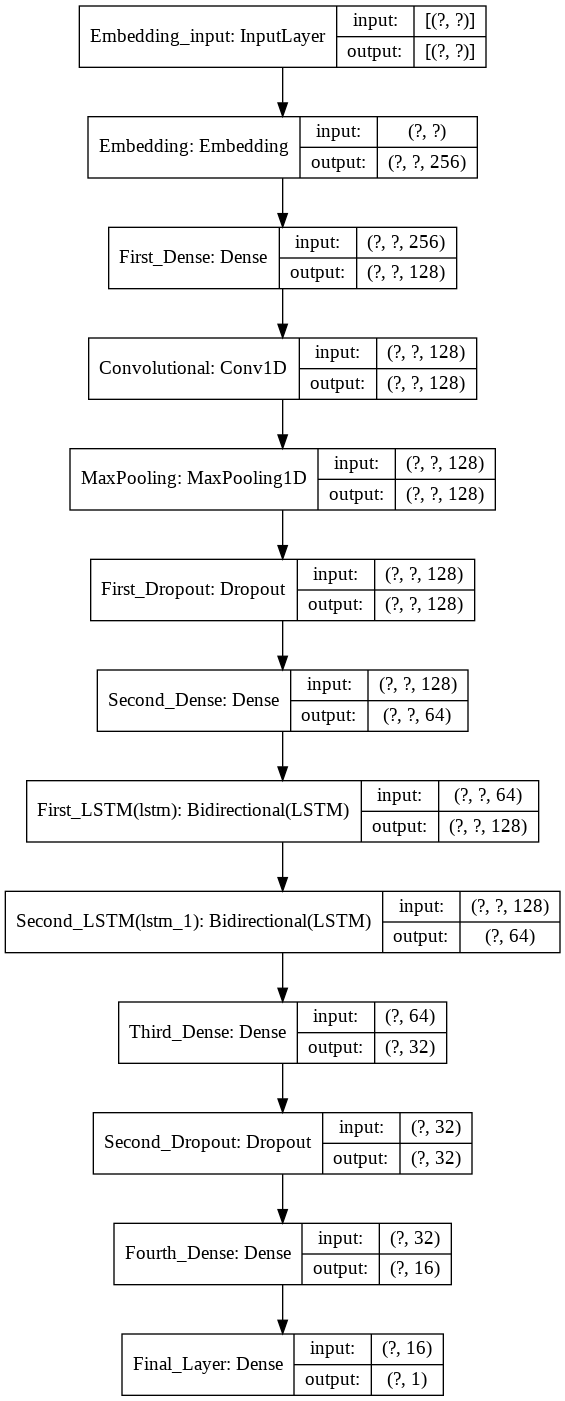

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [38]:
#Validation split set to 0.25 in order to have the following final split: 60% train, 20% validation and 20% test set.
history = model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=2, shuffle=True, validation_split=0.25)

Epoch 1/5
98/98 - 326s - loss: 0.3701 - accuracy: 0.8120 - val_loss: 0.1878 - val_accuracy: 0.9239
Epoch 2/5
98/98 - 331s - loss: 0.1371 - accuracy: 0.9501 - val_loss: 0.1216 - val_accuracy: 0.9569
Epoch 3/5
98/98 - 327s - loss: 0.1087 - accuracy: 0.9597 - val_loss: 0.1230 - val_accuracy: 0.9545
Epoch 4/5
98/98 - 331s - loss: 0.0685 - accuracy: 0.9758 - val_loss: 0.1521 - val_accuracy: 0.9540
Epoch 5/5
98/98 - 327s - loss: 0.0685 - accuracy: 0.9760 - val_loss: 0.1196 - val_accuracy: 0.9588


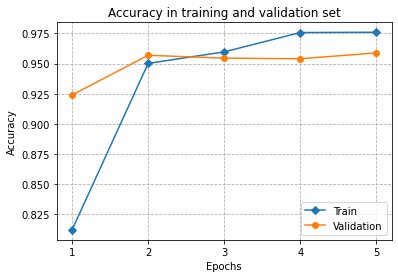

In [39]:
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Validation'])
plt.xticks(np.arange(0, 5, step=1), np.arange(1,6,step=1))
plt.title('Accuracy in training and validation set')
plt.grid(linestyle='--')
plt.savefig('accuracy.png')
plt.show()

In [69]:
text_evaluation = model.evaluate(X_test, y_test, verbose=1, batch_size=128)

33/33 [==============================] - 28s 840ms/step - loss: 0.1094 - accuracy: 0.9651


In [0]:
titleTokenizer = Tokenizer(num_words=300, lower=True)
titleTokenizer.fit_on_texts(texts=data_train['title'])
tX_train = titleTokenizer.texts_to_sequences(texts=data_train['title'])
tX_train = pad_sequences(sequences = tX_train, maxlen = 200, padding = 'post', truncating='post')
tX_test = titleTokenizer.texts_to_sequences(texts=data_test['title'])
tX_test = pad_sequences(sequences=tX_test, maxlen = 200, padding = 'post', truncating='post')

In [42]:
titleModel = tf.keras.models.Sequential([
            tf.keras.layers.Embedding(300, 128, name='Embedding'),
            tf.keras.layers.Dense(128, activation='relu', name='First_Dense'),
            tf.keras.layers.Conv1D(128, 3, activation='relu', name='Convolution'),
            tf.keras.layers.MaxPooling1D(4, name='MaxPooling'),
            tf.keras.layers.Dropout(0.2, name='Dropout'),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True), name='First_LSTM'),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu'), name='Second_LSTM'),
            tf.keras.layers.Dense(16, activation='relu', name='Second_Dense'),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(8, activation='relu', name='Third_Dense'),
            tf.keras.layers.Dense(1, activation='sigmoid', name='Final_layer')
], name='Titles_model')
titleModel.summary()

Model: "Titles_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, None, 128)         38400     
_________________________________________________________________
First_Dense (Dense)          (None, None, 128)         16512     
_________________________________________________________________
Convolution (Conv1D)         (None, None, 128)         49280     
_________________________________________________________________
MaxPooling (MaxPooling1D)    (None, None, 128)         0         
_________________________________________________________________
Dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
First_LSTM (Bidirectional)   (None, None, 128)         98816     
_________________________________________________________________
Second_LSTM (Bidirectional)  (None, 64)               

In [0]:
titleModel.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])

In [62]:
#Once again, validation split set to 0.25 to achieve 60/20/20 for train/validation/test
titleHist = titleModel.fit(tX_train,y_train,batch_size=64,epochs=5,verbose=2,validation_split=0.25)

Epoch 1/5
195/195 - 53s - loss: 0.2261 - acc: 0.9143 - val_loss: 0.2160 - val_acc: 0.9242
Epoch 2/5
195/195 - 53s - loss: 0.2115 - acc: 0.9205 - val_loss: 0.2120 - val_acc: 0.9266
Epoch 3/5
195/195 - 53s - loss: 0.1998 - acc: 0.9229 - val_loss: 0.2135 - val_acc: 0.9229
Epoch 4/5
195/195 - 57s - loss: 0.1908 - acc: 0.9254 - val_loss: 0.2094 - val_acc: 0.9244
Epoch 5/5
195/195 - 53s - loss: 0.1827 - acc: 0.9285 - val_loss: 0.2139 - val_acc: 0.9222


In [63]:
title_evaluation = titleModel.evaluate(tX_test, y_test, batch_size=64, verbose=1)

65/65 [==============================] - 4s 67ms/step - loss: 0.2067 - acc: 0.9220


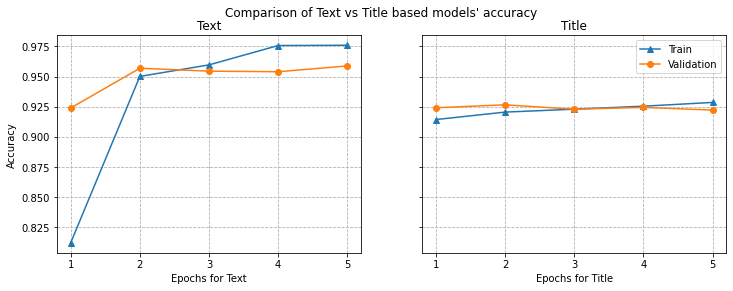

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.suptitle('Comparison of Text vs Title based models\' accuracy')
ax[0].set(xlabel='Epochs for Text', ylabel='Accuracy', title='Text')
ax[1].set(xlabel='Epochs for Title', title='Title')
ax[0].plot(history.history['accuracy'], marker='^')
ax[0].plot(history.history['val_accuracy'], marker='o')
ax[0].set_xticks(np.arange(0,5,step=1))
ax[0].set_xticklabels(np.arange(1,6,step=1))
ax[1].plot(titleHist.history['acc'], marker='^')
ax[1].plot(titleHist.history['val_acc'], marker='o')
ax[1].set_xticks(np.arange(0,5,step=1))
ax[1].set_xticklabels(np.arange(1,6,step=1))
ax[1].legend(['Train','Validation'])
ax[0].grid(linestyle='--')
ax[1].grid(linestyle='--')

plt.show()

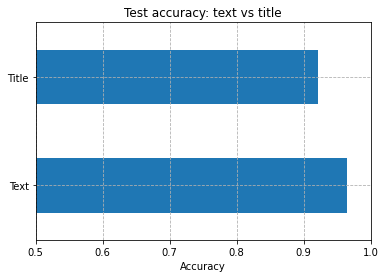

,Test accuracy
Text,0.965077
Title,0.921965


In [191]:
eval_df = pd.DataFrame([text_evaluation[1], title_evaluation[1]], columns=['Test accuracy'], index=['Text','Title'])
eval_df.plot(kind='barh')
plt.xlim([0.5,1])
plt.xlabel('Accuracy')
plt.legend().remove()
plt.title('Test accuracy: text vs title')
plt.grid(linestyle='--')
plt.show()
print('\n')
display(eval_df)